<a href="https://colab.research.google.com/github/givemethatsewon/urp-summer-2025/blob/main/onboarding/sewon-min/char_rnn_classification/char_rnn_classification_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Google Colab에서 노트북을 실행하실 때에는
# https://tutorials.pytorch.kr/beginner/colab 를 참고하세요.
%matplotlib inline


# 기초부터 시작하는 NLP: 문자-단위 RNN으로 이름 분류하기

**Author**: [Sean Robertson](https://github.com/spro)
  **번역**: [황성수](https://github.com/adonisues), [김제필](https://github.com/garlicvread)


여기에서는 단어를 분류하기 위해 기초적인 문자-단위의 순환 신경망(RNN, Recurrent Nueral Network)을
구축하고 학습할 예정입니다. 이 튜토리얼 및 이후 2개 튜토리얼인 :doc:`/intermediate/char_rnn_generation_tutorial`
및 :doc:`/intermediate/seq2seq_translation_tutorial` 에서는 자연어 처리(NLP, Natural Language Processing)
분야에서 어떻게 데이터를 전처리하고 NLP 모델을 구축하는지를 밑바닥부터(from scratch) 설명합니다.
이를 위해 이 튜토리얼 시리즈에서는 `torchtext` 의 수많은 편리한 기능들을 사용하지 않고
NLP 모델링을 위한 데이터 전처리가 밑바닥(low-level)에서 어떻게 진행되는지 알 수 있습니다.

문자-단위 RNN은 단어를 문자의 연속으로 읽어 들여서 각 단계의 예측과
"은닉 상태(Hidden State)"를 출력하고, 다음 단계에 이전 단계의 은닉 상태를 전달합니다.
단어가 속한 클래스로 출력되도록 최종 예측으로 선택합니다.

구체적으로, 18개 언어로 된 수천 개의 성(姓)을 훈련시키고,
철자에 따라 이름이 어떤 언어인지 예측합니다:

```sh
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```
## 준비 과정

이 튜토리얼을 시작하기 전, PyTorch를 이미 설치했으며, Python 프로그래밍 언어와
Tensor에 대한 기본적인 이해를 하고 계셔야 합니다:

-  https://pytorch.kr/ 에서 설치 안내를 찾을 수 있으며,
-  :doc:`/beginner/deep_learning_60min_blitz` 를 통해 PyTorch의 일반적인 내용과 Tensor에 대해 익힐 수 있습니다.
-  :doc:`/beginner/pytorch_with_examples` 는 넓고 깊은 개요(overview)를 제공하며,
-  :doc:`/beginner/former_torchies_tutorial` 이전 Lua Torch 사용자를 위한 자료입니다.

RNN과 그 작동 방식을 아는 것 또한 유용합니다:

-  [The Unreasonable Effectiveness of Recurrent Neural
   Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)_
   실생활 예제를 보여 줍니다.
-  [Understanding LSTM
   Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)_
   LSTM에 관한 것이지만 RNN에 관해서도 유익합니다.

## 데이터 준비

<div class="alert alert-info"><h4>Note</h4><p>[여기](https://download.pytorch.org/tutorial/data.zip)_ 에서 데이터를 다운로드 받고
   현재 디렉토리에 압축을 푸십시오.</p></div>

``data/names`` 디렉토리에는 ``[Language].txt`` 라는 18 개의 텍스트 파일이 있습니다.
각 파일에는 한 줄에 하나의 이름이 포함되어 있으며 대부분 로마자로 되어 있습니다.
(그러나, 유니코드에서 ASCII로 변환해야 함).

각 언어 별로 이름 목록 사전 ``{language: [names ...]}`` 을 만듭니다.
일반 변수 "category" 와 "line" (우리의 경우 언어와 이름)은 이후의 확장성을 위해 사용됩니다.

<div class="alert alert-info"><h4>Note</h4><p>역자 주: "line" 에 입력을 "category"에 클래스를 적용하여 다른 문제에도 활용할 수 있습니다.
   여기서는 "line"에 이름(ex. Robert)을 입력으로, "category"에 클래스(ex. english)로 사용합니다.</p></div>


In [25]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2025-07-14 11:08:54--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.239.225.55, 18.239.225.75, 18.239.225.61, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.239.225.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.09s   

2025-07-14 11:08:54 (29.9 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  infla

In [26]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Chinese.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/French.txt', 'data/names/Japanese.txt', 'data/names/Portuguese.txt', 'data/names/Italian.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Russian.txt', 'data/names/Vietnamese.txt', 'data/names/Scottish.txt', 'data/names/Czech.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Polish.txt']
Slusarski


이제 각 ``category`` (언어)를 ``line`` (이름)에 매핑하는 사전인
``category_lines`` 를 만들었습니다. 나중에 참조할 수 있도록
``all_categories`` (언어 목록)와 ``n_categories`` 도 추적합니다.




In [27]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### 이름을 Tensor로 변경

이제 모든 이름을 체계화했으므로, 이를 활용하기 위해 Tensor로
변환해야 합니다.

하나의 문자를 표현하기 위해 크기가 ``<1 x n_letters>`` 인
"One-Hot 벡터"를 사용합니다. One-Hot 벡터는 현재 문자의
주소에는 1이, 그 외 나머지 주소에는 0이 채워진 벡터입니다.
예시 ``"b" = <0 1 0 0 0 ...>`` .

단어를 만들기 위해 One-Hot 벡터들을 2차원 행렬
``<line_length x 1 x n_letters>`` 에 결합시킵니다.

위에서 보이는 추가적인 1차원은 PyTorch에서 모든 것이 배치(batch)에 있다고 가정하기
때문에 발생합니다. 여기서는 배치 크기 1을 사용하고 있습니다.




In [28]:
# .. note::
#    역자 주: One-Hot 벡터는 언어 및 범주형 데이터를 다룰 때 주로 사용하며,
#    단어, 글자 등을 벡터로 표현할 때 단어, 글자 사이의 상관 관계를 미리 알 수 없을 경우,
#    One-Hot으로 표현하여 서로 직교한다고 가정하고 학습을 시작합니다.
#    이와 동일하게, 상관 관계를 알 수 없는 다른 데이터의 경우에도 One-Hot 벡터를 활용할 수 있습니다.
#

import torch

# all_letters 로 문자의 주소 찾기, 예시 "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# 검증을 위해서 한 개의 문자를 <1 x n_letters> Tensor로 변환
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 한 줄(이름)을  <line_length x 1 x n_letters>,
# 또는 One-Hot 문자 벡터의 Array로 변경
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## 네트워크 생성

Autograd 전에, Torch에서 RNN(recurrent neural network) 생성은
여러 시간 단계 걸쳐서 계층의 매개변수를 복제하는 작업을 포함합니다.
계층은 은닉 상태와 변화도(Gradient)를 가지며, 이제 이것들은 그래프 자체에서
완전히 처리됩니다. 이는 feed-forward 계층과
같은 매우 "순수한" 방법으로 RNN을 구현할 수 있음을 의미합니다.

<div class="alert alert-info"><h4>Note</h4><p>역자 주: 여기서는 학습 목적으로 nn.RNN 대신 직접 RNN을 사용합니다.</p></div>

이 RNN 모듈은 "기본(vanilla)적인 RNN"을 구현하며, 입력과 은닉 상태(hidden state),
그리고 출력 뒤 동작하는 ``LogSoftmax`` 계층이 있는 3개의 선형 계층만을 가집니다.




In [29]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

이 네트워크의 한 단계를 실행하려면 입력(현재 문자 Tensor)과
이전의 은닉 상태(처음에는 0으로 초기화)를 전달해야 합니다.
출력(각 언어의 확률)과 다음 은닉 상태(다음 단계를 위해 유지)를
돌려받습니다.




In [30]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

효율성을 위해서 매 단계마다 새로운 Tensor를 만들고 싶지 않기 때문에
``letterToTensor`` 대신 ``lineToTensor`` 를 잘라서 사용할
것입니다. 이것은 Tensor의 사전 연산(pre-computing) 배치에 의해
더욱 최적화될 수 있습니다.




In [31]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8046, -3.0718, -2.9767, -2.9796, -2.8644, -2.8912, -2.8292, -2.7719,
         -2.9997, -2.8411, -2.9359, -2.9147, -2.8807, -2.7429, -2.8928, -2.8979,
         -2.9870, -2.8088]], grad_fn=<LogSoftmaxBackward0>)


보시다시피 출력은 ``<1 x n_categories>`` Tensor이고, 모든 항목은
해당 카테고리의 우도(likelihood)입니다(더 높은 것이 더 확률 높음).




## 학습

### 학습 준비

학습에 들어가기 전, 몇몇 도움이 되는 함수(helper function)를 만들어야 합니다.
첫째는 우리가 알아낸 각 카테고리의 우도(likelihood)인 네트워크 출력을 해석하는 함수입니다.
가장 큰 값의 주소를 알기 위해서 ``Tensor.topk`` 를 사용할 수 있습니다.

<div class="alert alert-info"><h4>Note</h4><p>역자 주: 네트워크 출력(각 카테고리의 우도, likelihood)으로 가장 확률이 높은
   카테고리의 이름(언어)과 카테고리 번호를 반환합니다.</p></div>




In [32]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)  # 텐서의 가장 큰 값 및 주소
    category_i = top_i[0].item()   # 텐서에서 정수 값으로 변경
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Scottish', 13)


학습 예시(하나의 이름과 그 언어)를 얻는 빠른 방법도 필요합니다.:




In [33]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Polites
category = Arabic / line = Hadad
category = German / line = Baumgartner
category = German / line = Martin
category = French / line = Labelle
category = Dutch / line = Aller
category = Polish / line = Jez
category = Polish / line = Zielinski
category = Portuguese / line = Rocha
category = Russian / line = Pochitalin


### 네트워크 학습

이제 이 네트워크를 학습하는 데 필요한 예시(학습 데이터)를 보여주고 추정합니다.
만일 틀렸다면 알려 줍니다.

RNN의 마지막 계층이 ``nn.LogSoftmax`` 이므로 손실 함수로
``nn.NLLLoss`` 가 적합합니다.




In [34]:
criterion = nn.NLLLoss()

각 학습 루프는 다음과 같습니다:

-  입력과 목표 Tensor 생성
-  0 로 초기화 된 은닉 상태 생성
-  각 문자 읽기

-  다음 문자를 위한 은닉 상태 유지

-  목표와 최종 출력 비교
-  역전파
-  출력과 손실 반환




In [35]:
learning_rate = 0.005  # 학습률을 너무 높게 설정하면 발산할 수 있고, 너무 낮으면 학습이 되지 않을 수 있습니다.

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # 매개변수의 경사도에 학습률을 곱해서 그 매개변수의 값에 더합니다.
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

이제 예시 데이터를 사용하여 실행해야 합니다. ``train`` 함수가 출력과 손실을
반환하기 때문에 추측을 화면에 출력하고 도식화를 위한 손실을 추적할 수
있습니다. 1000개의 예시 데이터가 있기 때문에 ``print_every`` 예제만
출력하고, 손실의 평균을 얻습니다.




In [36]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# 도식화를 위한 손실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # ``iter`` 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 전체 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 10s) 0.8414 Adamidis / Greek ✓
10000 10% (0m 21s) 3.2417 Ventimiglia / Russian ✗ (Italian)
15000 15% (0m 32s) 1.4509 Santos / Greek ✗ (Portuguese)
20000 20% (0m 45s) 0.6567 Luong / Vietnamese ✓
25000 25% (0m 55s) 0.9250 Pesaro / Italian ✓
30000 30% (1m 5s) 0.3112 Bach / Vietnamese ✓
35000 35% (1m 16s) 3.5718 Schenck / Czech ✗ (Dutch)
40000 40% (1m 27s) 0.8135 Glockner / German ✓
45000 45% (1m 38s) 2.1291 Madaidhin / Russian ✗ (Irish)
50000 50% (1m 49s) 0.4837 Allegro / Italian ✓
55000 55% (1m 59s) 0.5074 Fontaine / French ✓
60000 60% (2m 10s) 0.2720 Seok / Korean ✓
65000 65% (2m 20s) 0.0581 Rutkowski / Polish ✓
70000 70% (2m 31s) 4.0315 Sabbadin / Russian ✗ (Italian)
75000 75% (2m 42s) 1.0645 Pellar / Czech ✓
80000 80% (2m 52s) 1.7121 Janko / Korean ✗ (Russian)
85000 85% (3m 2s) 2.2413 Phocas / English ✗ (Greek)
90000 90% (3m 12s) 1.5830 Herrero / Italian ✗ (Spanish)
95000 95% (3m 23s) 0.9200 Kieu / Chinese ✗ (Vietnamese)
100000 100% (3m 33s) 2.2666 Couch / Irish ✗ (English

### 결과 도식화

``all_losses`` 를 이용한 손실 도식화는
네트워크의 학습을 보여줍니다:




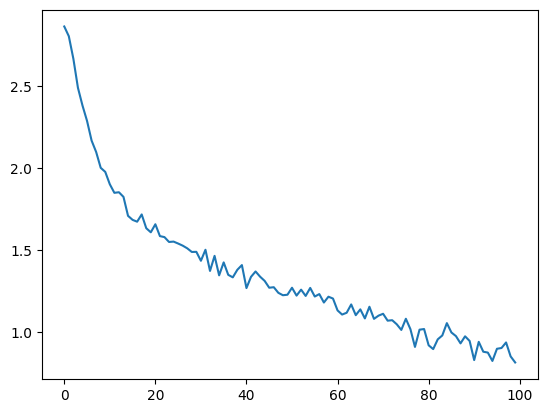

In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## 결과 평가

네트워크가 다른 카테고리에서 얼마나 잘 작동하는지 보기 위해
모든 실제 언어(행)가 네트워크에서 어떤 언어로 추측(열)되는지 나타내는
혼란 행렬(confusion matrix)을 만듭니다. 혼란 행렬을 계산하기 위해
``evaluate()`` 로 많은 수의 샘플을 네트워크에 실행합니다.
``evaluate()`` 은 ``train ()`` 과 역전파를 빼면 동일합니다.




/tmp/ipython-input-38-2811754854.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipython-input-38-2811754854.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


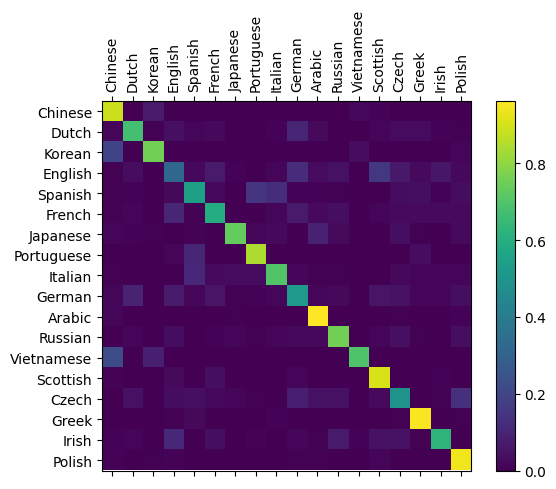

In [38]:
# 혼란 행렬에서 정확한 추측을 추적
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 주어진 라인의 출력 반환
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# 예시 중 어떤 것이 정확히 예측되었는지 기록
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 모든 행을 합계로 나누어 정규화
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 도식 설정
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 축 설정
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 모든 tick에서 레이블 지정
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

주축에서 벗어난 밝은 점을 선택하여 잘못 추측한 언어를 표시할 수 있습니다.
예를 들어 한국어는 중국어로 이탈리아어로 스페인어로.
그리스어는 매우 잘되는 것으로 영어는 매우 나쁜 것으로 보입니다.
(다른 언어들과의 중첩 때문으로 추정)




### 사용자 입력으로 실행




In [39]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.38) Russian
(-1.59) Czech
(-2.96) English

> Jackson
(-0.03) Scottish
(-3.92) English
(-5.40) Greek

> Satoshi
(-0.22) Japanese
(-2.10) Arabic
(-3.32) Polish


[실용 PyTorch 저장소](https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification)_
의 최종 버전 스크립트는 위 코드를 몇 개의 파일로 분할했습니다.:

-  ``data.py`` (파일 읽기)
-  ``model.py`` (RNN 정의)
-  ``train.py`` (학습 실행)
-  ``predict.py`` (커맨드 라인 인자로 ``predict()`` 실행)
-  ``server.py`` (``bottle.py`` 를 사용하여 JSON API로 예측 제공)

``train.py`` 를 실행하면 학습 및 신경망을 저장합니다.

``predict.py`` 를 실행하면 이름으로부터 예측을 실행합니다:

```sh
$ python predict.py Hazaki
(-0.42) Japanese
(-1.39) Polish
(-3.51) Czech
```
``server.py`` 를 실행하고 http://localhost:5533/Yourname 을 방문하면
예측 값에 대한 JSON 출력을 확인할 수 있습니다.




## 연습

-  "line -> category" 의 다른 데이터 집합으로 시도해 보십시오, 예를 들어:

   -  단어 -> 언어
   -  이름 -> 성별
   -  캐릭터 이름 -> 작가
   -  페이지 제목 -> 블로그 또는 서브레딧

-  더 크고 더 나은 모양의 네트워크로 더 나은 결과를 얻으십시오.

   -  더 많은 선형 계층을 추가해 보십시오.
   -  ``nn.LSTM`` 과 ``nn.GRU`` 계층을 추가해 보십시오.
   -  위와 같은 RNN 여러 개를 상위 수준 네트워크로 결합해 보십시오.


